In [1]:
using Distributions
using Rocket
using ReactiveMP
using BenchmarkTools
using Plots
using Random

import ProgressMeter

┌ Info: Precompiling ReactiveMP [a194aa59-28ba-4574-a09c-4a745416d6e3]
└ @ Base loading.jl:1278
┌ Warning: Package ReactiveMP does not have Rocket in its dependencies:
│ - If you have ReactiveMP checked out for development and have
│   added Rocket as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with ReactiveMP
└ Loading Rocket into ReactiveMP from project dependency, future warnings for ReactiveMP are suppressed.


In [2]:
function hgf_timeslice(model, zt_prev, xt_prev, real_k, real_w, z_variance, y_variance)
    
    zvar = constvar(model, :zvar, z_variance)
    zt   = randomvar(model, :zt)

    z_transition = make_node(model, NormalMeanVariance, zt, zt_prev, zvar, factorisation = ((1,),(2,),(3,)))
    
    xt = randomvar(model, :xt)
    kt = constvar(model, :kt, real_k)
    ωt = constvar(model, :wt, real_w)
    
    gcv = make_node(model, GCV, xt, xt_prev, zt, kt, ωt)
    
    y_var = constvar(model, :y_var, y_variance)
    y     = datavar(model, :y, Dirac{Float64})
    
    obs = make_node(model, NormalMeanVariance, y, xt, y_var)
    
    return (zt, xt, y, gcv)
end

function hgf(n, iters, data, real_k, real_w, z_variance, y_variance)
    model = Model()
    
    zs = Vector{RandomVariable}(undef, n)
    xs = Vector{RandomVariable}(undef, n)
    ys = Vector{DataVariable}(undef, n)
    
    zt_1_mean = datavar(model, :zt_1_mean, Dirac{Float64})
    zt_1_var  = datavar(model, :zt_1_var, Dirac{Float64})
    zt_1      = randomvar(model, :zt_1)
    
    xt_1_mean = datavar(model, :xt_1_mean, Dirac{Float64})
    xt_1_var  = datavar(model, :xt_1_var, Dirac{Float64})
    xt_1      = randomvar(model, :xt_1)
    
    zt_1_prior = make_node(model, NormalMeanVariance, zt_1, zt_1_mean, zt_1_var)
    xt_1_prior = make_node(model, NormalMeanVariance, xt_1, xt_1_mean, xt_1_var)  
    
    prev_zt_n = zt_1
    prev_xt_n = xt_1
    
    mz = Vector{NormalMeanVariance}(undef, n)
    mx = Vector{NormalMeanVariance}(undef, n)
    gcv = Vector{FactorNode}(undef, n)
    
    mz_subs = Vector{Teardown}(undef, n)
    mx_subs = Vector{Teardown}(undef, n)
    
    ms_scheduler = PendingScheduler()

    for i in 1:n
        zt_n, xt_n, y_n, gcv_n = hgf_timeslice(model, prev_zt_n, prev_xt_n, real_k, real_w, z_variance, y_variance)
        
        zs[i] = zt_n
        xs[i] = xt_n
        ys[i] = y_n
        gcv[i] = gcv_n
        
        mz_subs[i] = subscribe!(getmarginal(zt_n) |> schedule_on(ms_scheduler), (t) -> mz[i] = getdata(t))
        mx_subs[i] = subscribe!(getmarginal(xt_n) |> schedule_on(ms_scheduler), (t) -> mx[i] = getdata(t))
    
        prev_zt_n = zt_n
        prev_xt_n = xt_n
    end
    
    activate!(model)
    
    foreach(gcv) do gcv_node
        setmarginal!(gcv_node, :y_x, MvNormalMeanCovariance([ 0.0, 0.0 ], [ 5.0, 5.0 ]))
        setmarginal!(gcv_node, :z, NormalMeanVariance(0.0, 5.0)) 
    end
    
    # Initial messages
    prior_zt = NormalMeanVariance(0.0, 100.0)
    prior_xt = NormalMeanVariance(0.0, 100.0)
    
    fe = Vector{Float64}()
    
    fe_scheduler = PendingScheduler()
    fe_sub = subscribe!(score(BetheFreeEnergy(), model, fe_scheduler), (d) -> push!(fe, d))
    
    for _ in 1:iters
        update!(zt_1_mean, mean(prior_zt))
        update!(zt_1_var, var(prior_zt))
        update!(xt_1_mean, mean(prior_xt))
        update!(xt_1_var, var(prior_xt))

        for i in 1:n
            update!(ys[i], data[i])
        end
        
        release!(fe_scheduler)
    end
    
    release!(ms_scheduler)
 
    foreach(unsubscribe!, mz_subs)
    foreach(unsubscribe!, mx_subs)
    unsubscribe!(fe_sub)
    
    return mz, mx, fe
end

hgf (generic function with 1 method)

In [3]:
n = 1000
iters = 10

Random.seed!(123)

real_k = 1.0
real_w = 0.0

z_prev     = 0.0
z_variance = 0.1

z = Vector{Float64}(undef, n)
for i in 1:n
    z[i] = rand(Normal(z_prev, sqrt(z_variance)))
    z_prev = z[i]
end

# z = map(d -> 2.0 * sin(0.005 * d), 1:n)

v = map(d -> exp(real_k * d + real_w), z)

x_prev = 0.0

x = Vector{Float64}(undef, n)

for i in 1:n
    x[i] = rand(Normal(x_prev, sqrt(v[i])))
    x_prev = x[i]
end

y = Vector{Float64}(undef, n)
y_variance = 1.0

for i in 1:n
    y[i] = rand(Normal(x[i], sqrt(y_variance)))
end

In [4]:
@time mz, mx, fe = hgf(n, iters, y, real_k, real_w, z_variance, y_variance); # Initial compilation

 20.949477 seconds (64.87 M allocations: 3.230 GiB, 8.09% gc time)


In [5]:
@time mz, mx, fe = hgf(n, iters, y, real_k, real_w, z_variance, y_variance); # Subsequent runs

  0.883391 seconds (4.76 M allocations: 254.897 MiB, 20.16% gc time)


In [6]:
@btime hgf($n, $iters, $y, $real_k, $real_w, $z_variance, $y_variance); # Benchmark

  867.945 ms (4755862 allocations: 254.90 MiB)


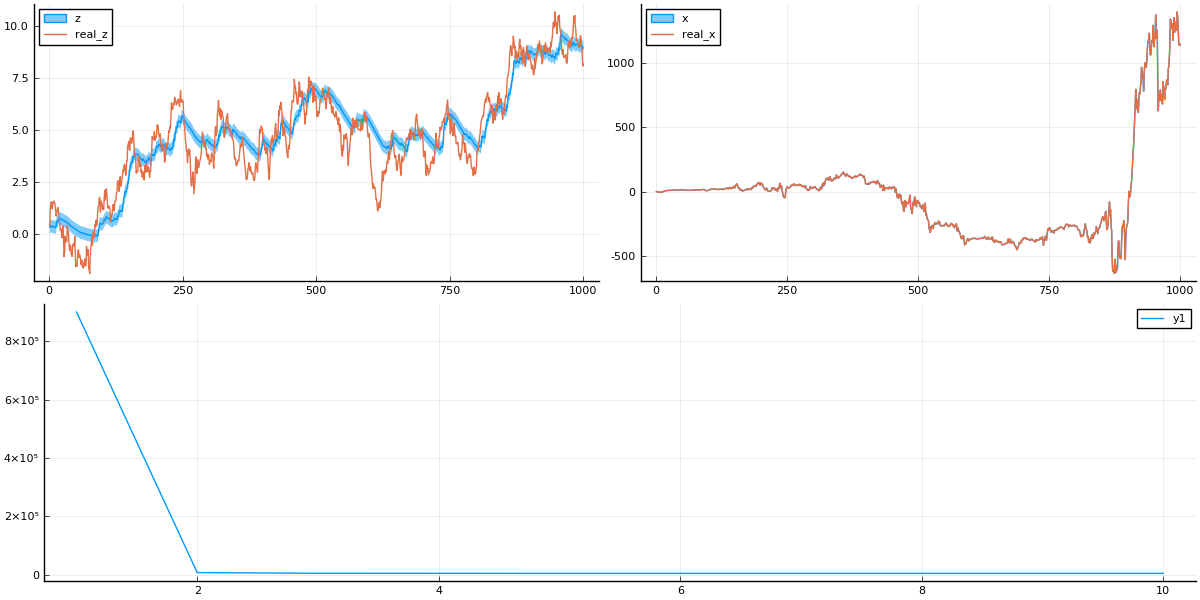

In [9]:
pyplot()

p1 = plot(mean.(mz), ribbon = std.(mz), label = :z)
p1 = plot!(p1, z, label = :real_z)

p2 = plot(mean.(mx), ribbon = std.(mx), label = :x)
p2 = plot!(p2, x, label = :real_x)

p3 = plot(fe)

plot(p1, p2, p3, layout = @layout([ a b; c ]), size = (1200, 600))